# Dusty Dwarves Rotation Method

| Nickname  | Main ID (CDS Portal)                        | Target                   | RA            | DEC          | Quick Link (F125W)                                                         |
|-----------|---------------------------------------------|--------------------------|---------------|--------------|----------------------------------------------------------------------------|
| DD_Soft   | VV 185, MCG+03-31-012                       | SDSS-J120049.26+152704.3 | 12:00:49.260  | +15:27:4.30  | https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=IDJ003031 |
| DD_Bar    | IC4271                                      | SDSS-J132921.43+372450.4 | 13:29:21.4300 | +37:24:50.40 | https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=IDJ007S5Q |
| DD_Smooth | 2MASX J15192312+2032335, CGCG 135-044 NED01 | SDSS-J151923.14+203233.6 | 15:19:23.1400 | +20:32:33.60 | https://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=IDJ002J5Q |

**Set your starting options here:**
* nick: Save location and the nickname that will appear in saved files.
* path: The path from TheOG to the data file.
* sci: Location of the science image (index). Typically 0 or 1.
* need_cutout: If the target is very small within the original image, you may want to use a smaller cutout of the image.
* pos,size: if need_cutout=True, then specific approximate center (x,y) of area of interest, and size of desired cutout (px).

(Python 3.12.3)

## Imports

In [16]:
from TheOG.utils import *
import TheOG.rotate_tools as rot
import TheOG.isophote_tools as iso

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import SigmaClip # class
from astropy.stats import sigma_clip
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.visualization import ZScaleInterval

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from photutils.background import Background2D, MedianBackground

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [17]:
# science index of data (usually 0, but 1 in this case)
sci = 1

starting_path = 'dusty_dwarves_data/SDSS_Soft_F606W/idj003031_drc.fits' # path to original data
nick = 'DD_Soft_606'                                                    # nickname applied to file names
file = 'dusty_dwarves_output/DD_Soft_606'                               # saved and working location. Includes the nickname.
pos,size = (2091,2492),(1200, 1200)                                     # cutout position and size

# starting_path = 'dusty_dwarves_data/SDSS_Bar_F125W/idj007s5q_drz.fits'
# nick = 'DD_Bar_125'
# path = 'dusty_dwarves_output/DD_Bar_125'
# pos,size = (570,530),(800, 800)

# starting_path = 'dusty_dwarves_data/SDSS_Smooth_F125W/idj002j5q_drz.fits'
# nick = 'DD_Smooth_125'
# path = 'dusty_dwarves_output/DD_Smooth_125' 
# pos,size = (607,500),(1000, 1000)

Filename: dusty_dwarves_data/SDSS_Soft_F606W/idj003031_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     849   ()      
  1  SCI           1 ImageHDU        93   (4124, 4385)   float32   
  2  WHT           1 ImageHDU        45   (4124, 4385)   float32   
  3  CTX           1 ImageHDU        40   (4124, 4385)   int32   
  4  HDRTAB        1 BinTableHDU    559   4R x 275C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 19A, 4A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 4A, 18A, 3A, K, 5A, 4A, D, 13A, 8A, 4A, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, D, D, D, D,

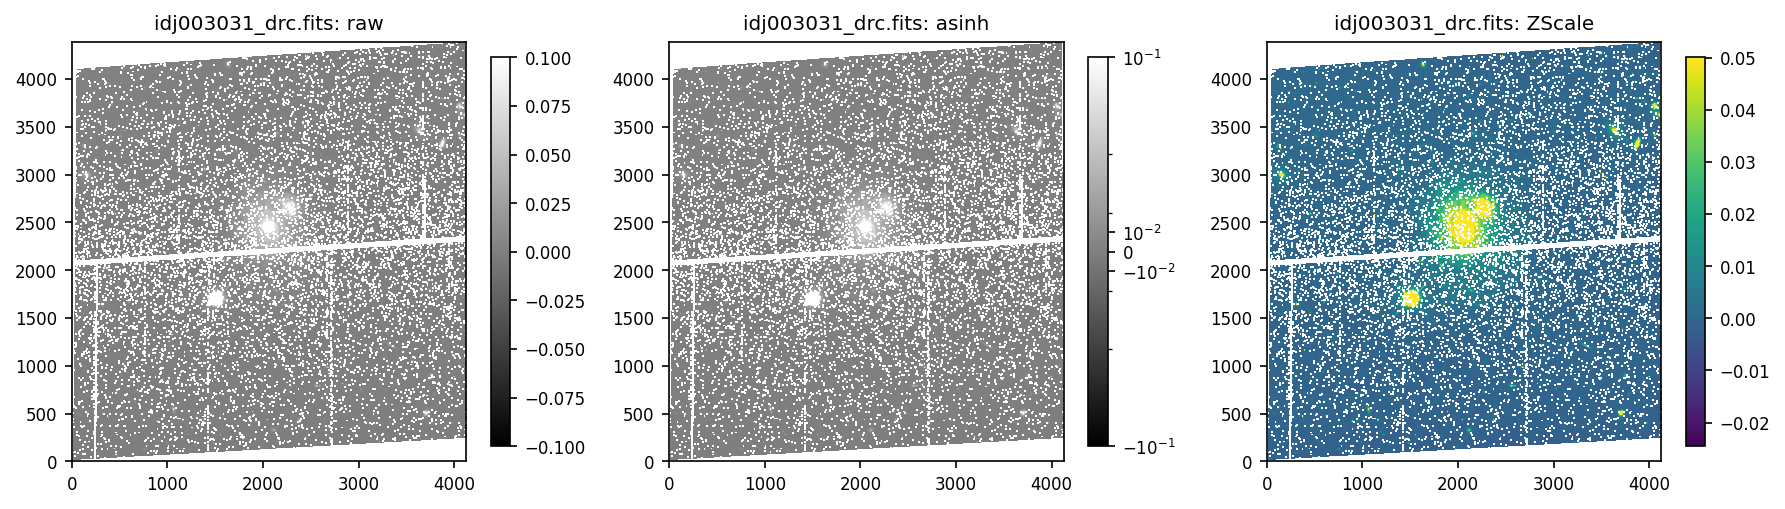

In [26]:
# quickly opens and plots the raw data
hdulist0, image_data0, prihdr0 = quick_open(starting_path, sci)

Filename: dusty_dwarves_data/SDSS_Soft_F606W/idj003031_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     849   ()      
  1  SCI           1 ImageHDU        93   (4124, 4385)   float32   
  2  WHT           1 ImageHDU        45   (4124, 4385)   float32   
  3  CTX           1 ImageHDU        40   (4124, 4385)   int32   
  4  HDRTAB        1 BinTableHDU    559   4R x 275C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 19A, 4A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 7A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 4A, 18A, 3A, K, 5A, 4A, D, 13A, 8A, 4A, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, D, D, D, D,

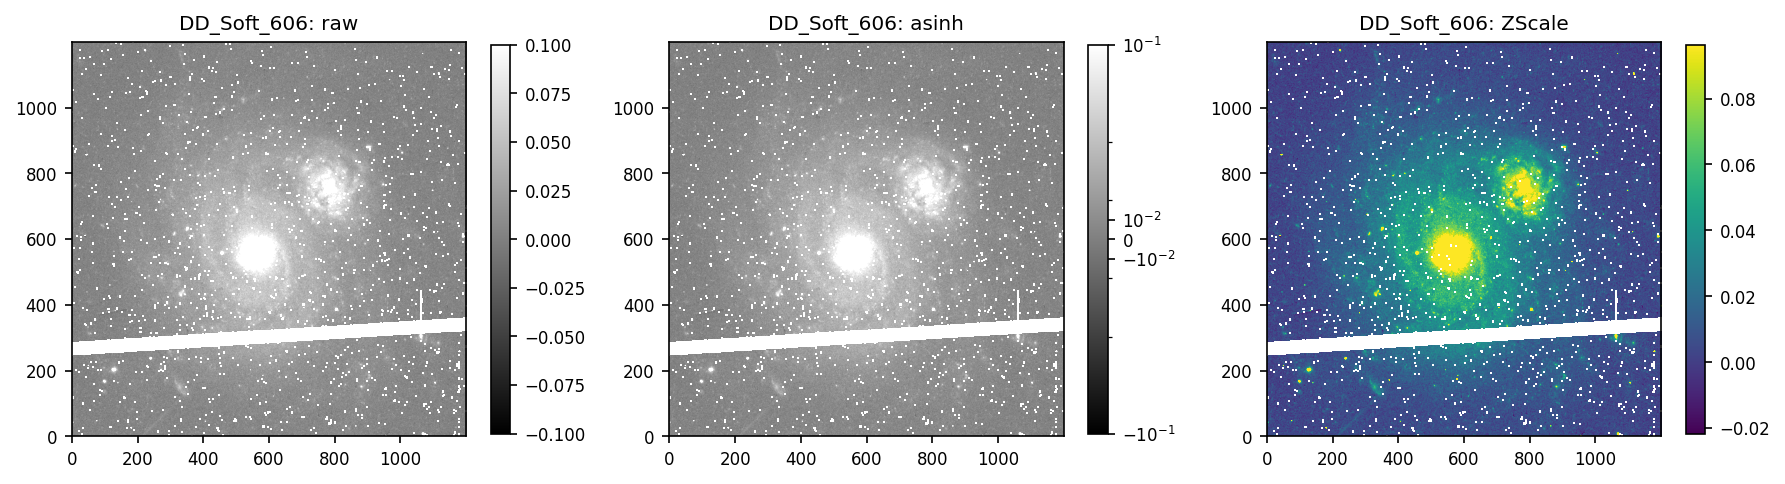

In [25]:
# creates a working file, and use a cutout if needed
hdulist, image_data, prihdr = create_working_file(path=starting_path, sci=sci, file=file, cutout=True, pos=pos, size=size)

# quickly plots the cutout data
quick_plot(image_data, name=nick)

## Set Apertures

In [28]:
rot.drawregions(fitsfile=file+'.fits', science=sci)

data shape:	 (1200, 1200)

Please open DS9 with the newly generated .reg file and move
the x to the forground galaxy center, 
the + to the background galaxy center, 
the blue ellipse to encompass the foreground galaxy, and
the red ellipse to encompass the background galaxy.

WHEN SAVING, OPT FOR IMAGE so everything is in PIXELS for TheOG to deal with.
Best practice is to make a separate .reg file in WCS.


TIPS for setting regions in ds9: 
* If you use a cutout, make sure to make the regions on the cutout fits file instead of the original.
* Use a scale where it's easy to identify the centers of the galaxies, and place the center markers.
* The closer the markers are to the center, the better the transmission plots will be.
* Use the information panels to set the elipses at the same position as the markers.
* Encompass the entire visible region of the galaxy.
* Regions should be overlapping.
* Save the region with IMAGE coordinate system.
* Specify the file extension .reg to avoid errors.

Name the file 'nick_regions.reg', using the chosen nickname. Add '_regions' to the name so running rot.drawregions again doesn't overwrite the file.

In [31]:
x0_fg,y0_fg,a_fg,b_fg,pa_fg, x0_bg,y0_bg,a_bg,b_bg,pa_bg  = rot.readregion(file+'_regions.reg')

print(x0_fg,y0_fg,a_fg,b_fg,pa_fg, x0_bg,y0_bg,a_bg,b_bg,pa_bg)

# Region file format: DS9 version 4.1

global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1

image

point(562.70003,558.35499) # point=x 15 color=red text={BG center}

Found the background galaxy center marker!
562.70003 558.35499
point(781.20878,752.22996) # point=cross 15 color=blue text={FG center}

Found the foreground galaxy center marker!
781.20878 752.22996
ellipse(781.20878,752.22996,133.75971,137.30338,1.554444e-06) # color=blue

Found the foreground galaxy ellipse!
781.20878 752.22996 133.75971 137.30338 1.554444e-06 

ellipse(562.70003,558.35499,361.57193,319.37506,94.424473) # color=red

Found the background galaxy ellipse!
562.70003 558.35499 361.57193 319.37506 94.424473 

circle(243.304,924.136,0) # color=red

781.20878 752.22996 133.75971 137.30338 1.554444e-06 562.70003 558.35499 361.57193 319.37506 94.424473


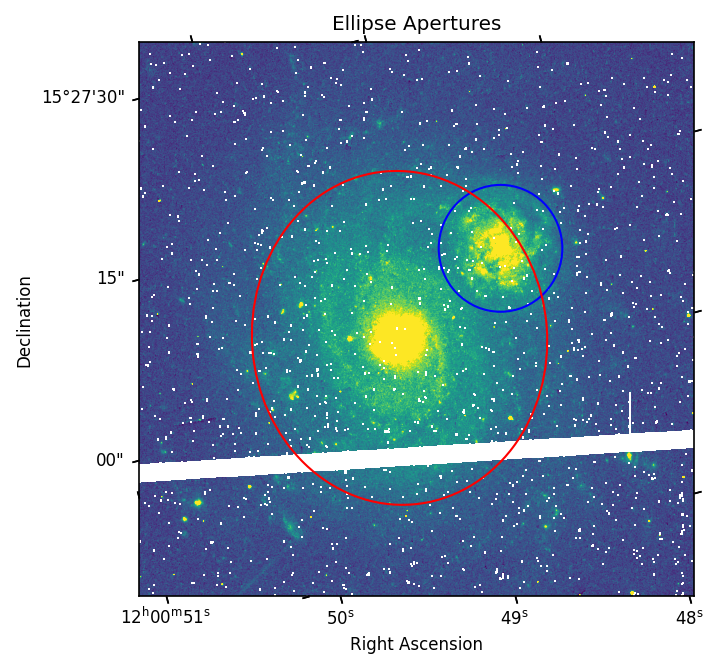

In [34]:
#defining aperture collections:
aper_fg = (x0_fg,y0_fg,a_fg,b_fg,pa_fg)
aper_bg = (x0_bg,y0_bg,a_bg,b_bg,pa_bg)

rot.plot_ellipses(image_data, prihdr, aper_fg, aper_bg, figname=file+'_elip_aper.png', ZScale=True)

## Rotation Method


input position (x,y) in px:	 781.20878, 752.22996
input position (ra,dec) in deg:	 180.20228422501924, 15.45265381579374

original position:	 (781, 752)
original shape:		 (1200, 1200)
cutout shape:		 (7572, 7572)
cutout corners:		 x:(-3005, 4567), y:(-3034, 4538) 


input position (x,y) in px:	 562.70003, 558.35499
input position (ra,dec) in deg:	 180.2052671435217, 15.451215204552636

original position:	 (563, 558)
original shape:		 (1200, 1200)
cutout shape:		 (7572, 7572)
cutout corners:		 x:(-3223, 4349), y:(-3228, 4344) 



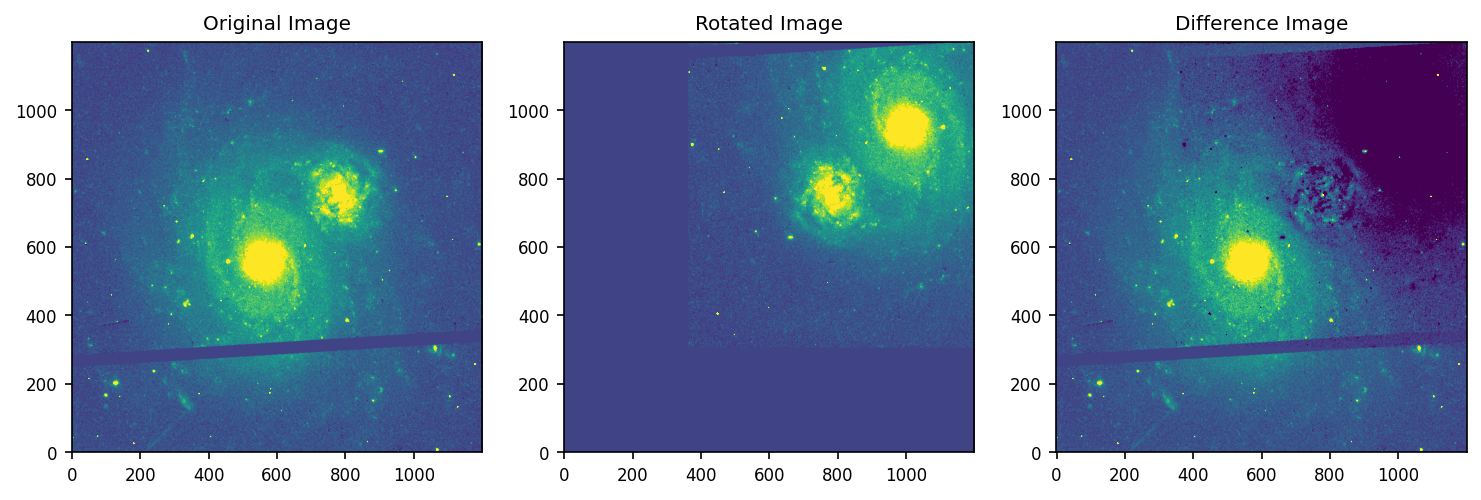

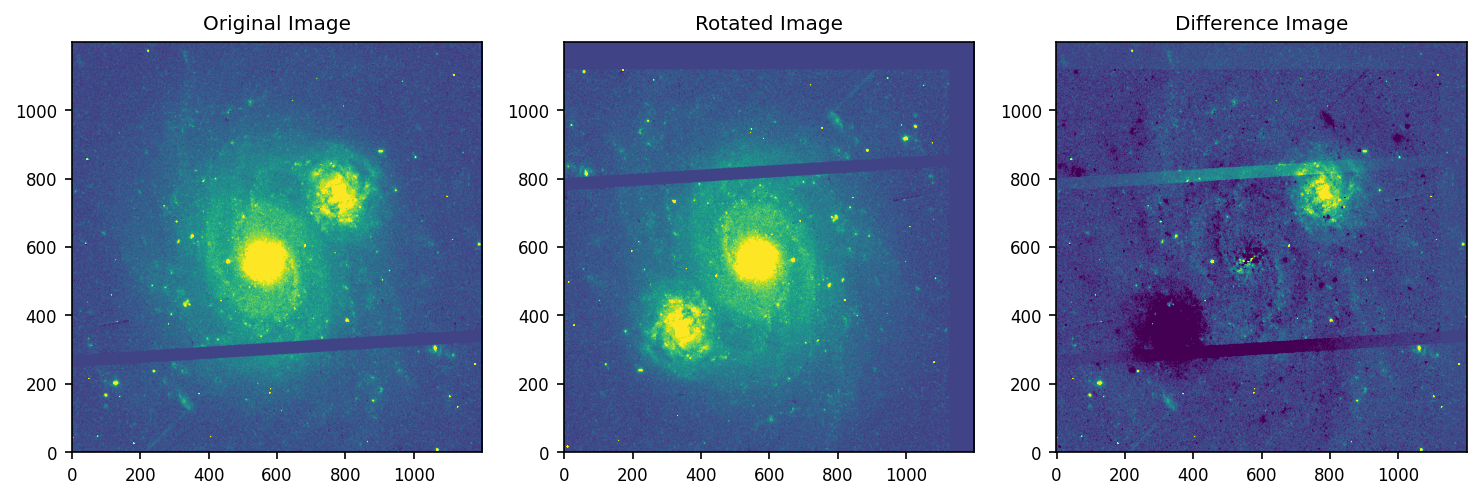

In [37]:
# Note: With JWST images, 'WARNING: FITSFixedWarning' shows up. This is suppressed in Image_tools.

# foreground
fg_rot_model = rot.imrotate(data=image_data,header=prihdr, x0=x0_fg, y0=y0_fg, dimen=u.Quantity((5, 5), u.arcmin), rotangle=180.,  
                           figname=file+'_foreground_rotated.png',ZScale=True)

# background
bg_rot_model = rot.imrotate(data=image_data,header=prihdr, x0=x0_bg, y0=y0_bg, dimen=u.Quantity((5, 5), u.arcmin), rotangle=180.,  
                           figname=file+'_background_rotated.png',ZScale=True)

Try jiggle and rotate to get a better center of the region.
* This function takes much longer to run (2-10 mins each), so choose the pixel range and pixel steps carefully.
* Manual:
    * Look at your image, and choose a distance from your center point where you think the best center is located (pixrange).
    * Then choose how many steps within the range you want to check for a better center (pixelstep.)
* Automatic:
    * Open ds9 and the nick_regions.reg file created earlier. Adjust ellipses to suround the area where you beleive the best center is located. 
    * Save the file as 'nick_center_regions.reg'.
    * Do not change the centers of the regions, as the code won't recognize the change # this could easily be changed later if I wanted
    * Adding the .reg file will make the function run on automatic mode, leaving pixrange and pixelstep manual values to be ignored.
* The best *change* in the center is returned, along with plots of the best images.

pixrange = 45
pixelstep = 9
checking -45,-45
new best center: difference 1.6789775801589713
checking -45,-36
new best center: difference 1.6678758112248033
checking -45,-27
new best center: difference 1.6363725027767941
checking -45,-18
new best center: difference 1.630390775797423
checking -45,-9
checking -45,0
checking -45,9
checking -45,18
checking -45,27
new best center: difference 1.6058468865812756
checking -45,36
checking -36,-45
checking -36,-36
new best center: difference 1.571796338481363
checking -36,-27
new best center: difference 1.4653899009572342
checking -36,-18
new best center: difference 1.4459099651430734
checking -36,-9
checking -36,0
new best center: difference 1.4412273390917107
checking -36,9
checking -36,18
checking -36,27
new best center: difference 1.3970855831867084
checking -36,36
checking -27,-45
checking -27,-36
checking -27,-27
new best center: difference 1.3220919286832213
checking -27,-18
new best center: difference 1.2349868101300672
checking -27,-9
ch

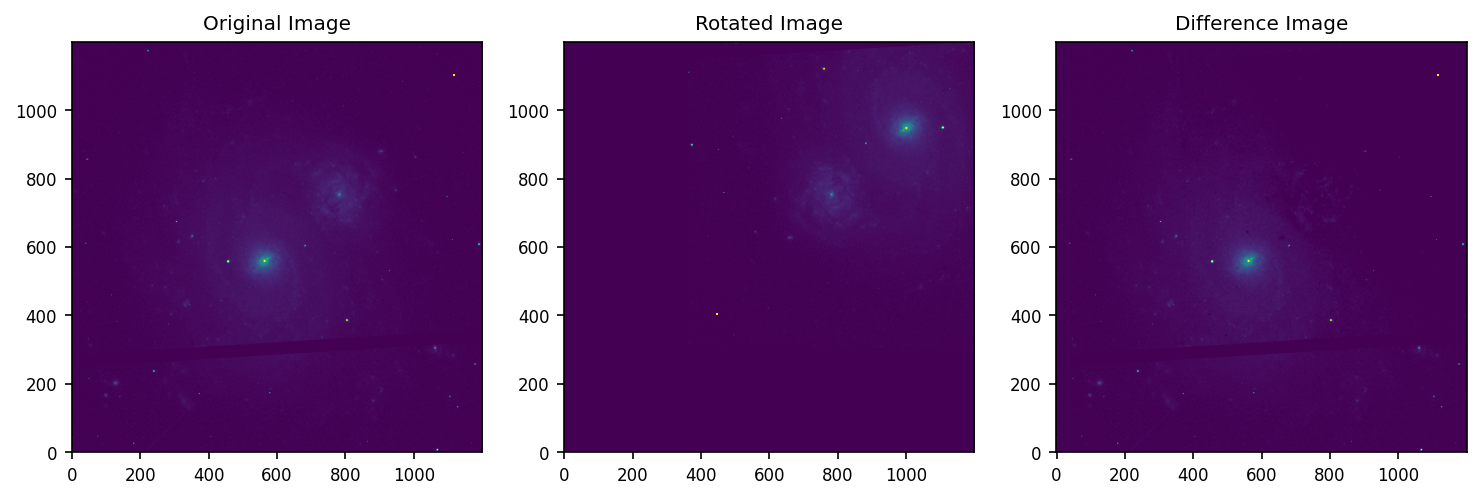

In [ ]:
# foreground rough (no fine tuning)

# fg_dx, fg_dy = rot.jiggle_and_rotate(data=image_data,header=prihdr,x0=x0_fg,y0=y0_fg,pixrange=20,pixelstep=4,figname=file+'_fg_jiggle.png', 
#                                             regfile=file+'_center_regions.reg', foreground=True)
# print(fg_dx,fg_dy)

pixrange = 9
pixelstep = 1
checking -9,-9
new best center: difference 1.1241965519147925
checking -9,-8
checking -9,-7
checking -9,-6
checking -9,-5
checking -9,-4
checking -9,-3
checking -9,-2
checking -9,-1
checking -9,0
checking -9,1
checking -9,2
checking -9,3
checking -9,4
checking -9,5
checking -9,6
new best center: difference 1.119658298266586
checking -9,7
new best center: difference 1.053956400428433
checking -9,8
new best center: difference 1.0064826805028133
checking -8,-9
checking -8,-8
checking -8,-7
checking -8,-6
checking -8,-5
checking -8,-4
checking -8,-3
checking -8,-2
checking -8,-1
checking -8,0
checking -8,1
checking -8,2
checking -8,3
checking -8,4
checking -8,5
checking -8,6
checking -8,7
checking -8,8
checking -7,-9
checking -7,-8
checking -7,-7
checking -7,-6
checking -7,-5
checking -7,-4
checking -7,-3
checking -7,-2
checking -7,-1
checking -7,0
checking -7,1
checking -7,2
checking -7,3
checking -7,4
checking -7,5
checking -7,6
checking -7,7
checking -7,8
chec

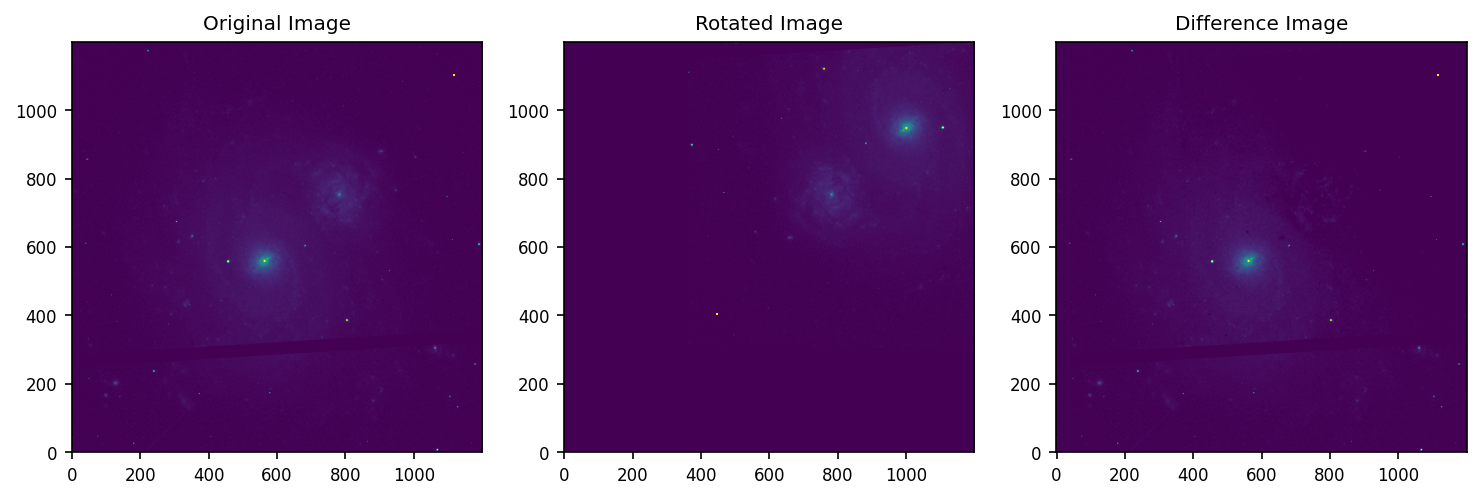

In [ ]:
# foreground, now using finetune to check around the new best point

# fg_dx, fg_dy = rot.jiggle_and_rotate(data=image_data,header=prihdr,x0=x0_fg+fg_dx,y0=y0_fg+fg_dy,pixrange=20,pixelstep=4,figname=file+'_fg_jiggle.png', 
#                                             regfile=file+'_center_regions.reg', foreground=True, finetune=True)
# print(fg_dx,fg_dy)

pixrange = 48
pixelstep = 9
checking -48,-48
checking -48,-39
checking -48,-30
checking -48,-21
checking -48,-12
checking -48,-3
checking -48,6
checking -48,15
checking -48,24
checking -48,33
checking -48,42
checking -39,-48
checking -39,-39
checking -39,-30
checking -39,-21
checking -39,-12
checking -39,-3
checking -39,6
checking -39,15
checking -39,24
checking -39,33
checking -39,42
checking -30,-48
checking -30,-39
checking -30,-30
checking -30,-21
checking -30,-12
checking -30,-3
checking -30,6
checking -30,15
checking -30,24
checking -30,33
checking -30,42
checking -21,-48
checking -21,-39
checking -21,-30
checking -21,-21
checking -21,-12
checking -21,-3
checking -21,6
checking -21,15
checking -21,24
checking -21,33
checking -21,42
checking -12,-48
checking -12,-39
checking -12,-30
checking -12,-21
checking -12,-12
checking -12,-3
checking -12,6
checking -12,15
checking -12,24
checking -12,33
checking -12,42
checking -3,-48
checking -3,-39
checking -3,-30
checking -3,-21
checking

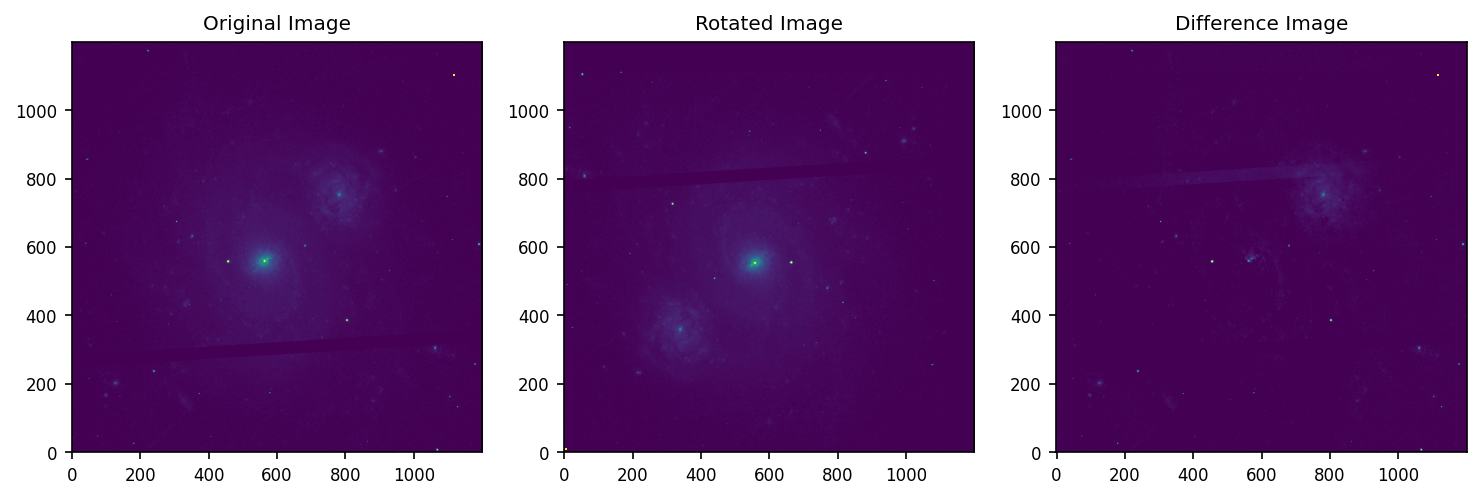

In [ ]:
# background rough (no fine tuning)

# bg_dx, bg_dy = rot.jiggle_and_rotate(data=image_data,header=prihdr,x0=x0_bg,y0=y0_bg,pixrange=10,pixelstep=1,figname=file+'_bg_jiggle.png',
#                                     regfile=file+'_center_regions.reg', foreground=False)
# print(bg_dx,bg_dy)

pixrange = 9
pixelstep = 1
checking -9,-9
checking -9,-8
checking -9,-7
checking -9,-6
checking -9,-5
checking -9,-4
checking -9,-3
checking -9,-2
checking -9,-1
checking -9,0
checking -9,1
checking -9,2
checking -9,3
checking -9,4
checking -9,5
checking -9,6
checking -9,7
checking -9,8
checking -8,-9
checking -8,-8
checking -8,-7
checking -8,-6
checking -8,-5
checking -8,-4
checking -8,-3
checking -8,-2
checking -8,-1
checking -8,0
checking -8,1
checking -8,2
checking -8,3
checking -8,4
checking -8,5
checking -8,6
checking -8,7
checking -8,8
checking -7,-9
checking -7,-8
checking -7,-7
checking -7,-6
checking -7,-5
checking -7,-4
checking -7,-3
checking -7,-2
checking -7,-1
checking -7,0
checking -7,1
checking -7,2
checking -7,3
checking -7,4
checking -7,5
checking -7,6
checking -7,7
checking -7,8
checking -6,-9
checking -6,-8
checking -6,-7
checking -6,-6
checking -6,-5
checking -6,-4
checking -6,-3
checking -6,-2
checking -6,-1
checking -6,0
checking -6,1
checking -6,2
checking -6,3

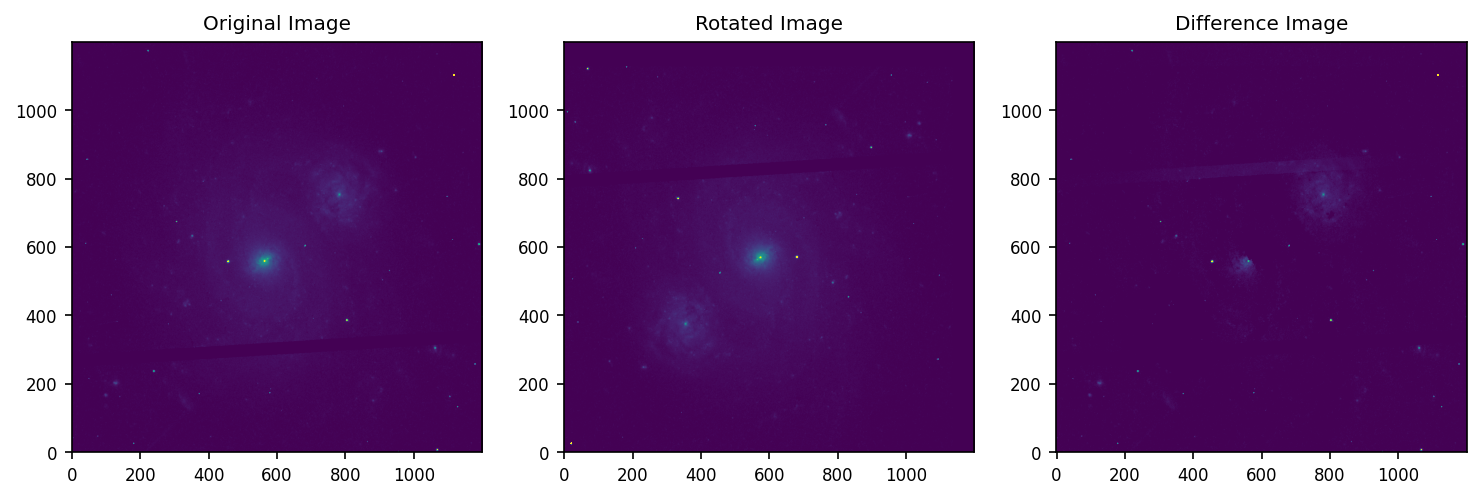

In [ ]:
# background, now using finetune to check around the new best point

# bg_dx, bg_dy = rot.jiggle_and_rotate(data=image_data,header=prihdr,x0=x0_bg+bg_dx,y0=y0_bg+bg_dy,pixrange=20,pixelstep=4,figname=file+'_bg_jiggle.png', 
#                                             regfile=file+'_center_regions.reg', foreground=True, finetune=True)
# print(bg_dx,bg_dy)

In [75]:
x0_fg_jiggle = x0_fg + fg_dx
y0_fg_jiggle = y0_fg + fg_dy

x0_bg_jiggle = x0_bg + bg_dx
y0_bg_jiggle = y0_bg + bg_dy

c:\Users\dogfi\Documents\Research\OAKS\Python\OverlappingGalaxies\TheOG\rotate_tools.py:572: RuntimeWarning: overflow encountered in divide
  cbar = fig.colorbar(im, ax=ax, shrink=sh)


Aperture Growth Factor:	 2.0
Foreground	 major axis:	 133.75971	 minor axis:	137.30338
Background	 major axis:	 361.57193	 minor axis:	319.37506


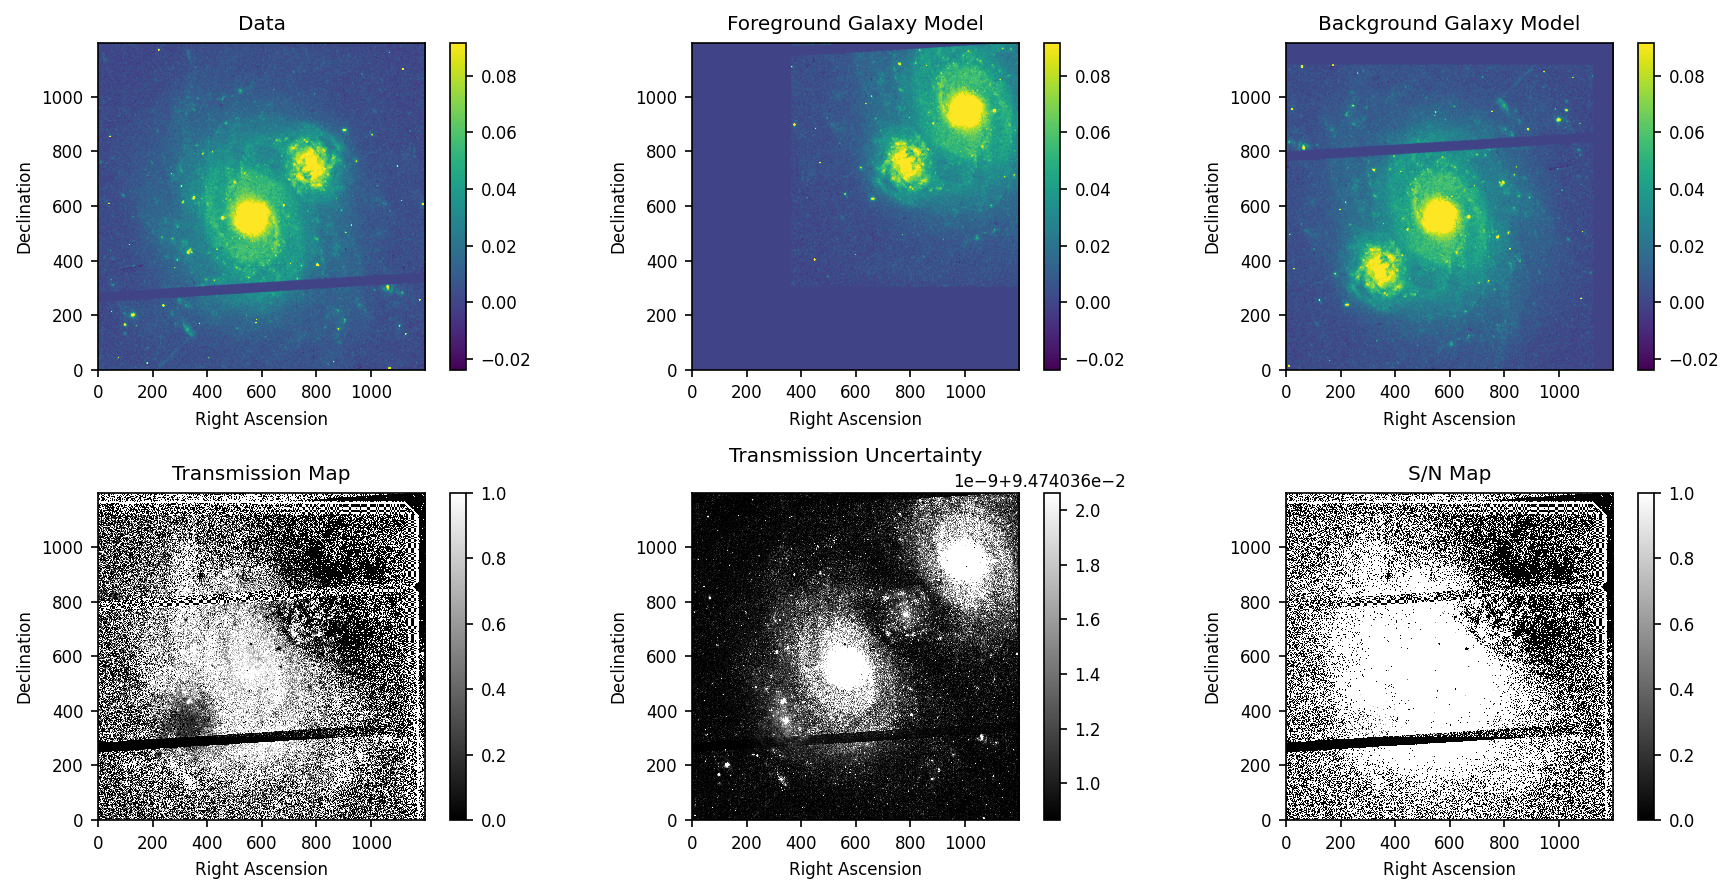

In [85]:
# If jiggle_and_rotate gave desirable results, add the change here:

aper_fg = (x0_fg_jiggle,y0_fg_jiggle,a_fg,b_fg,pa_fg)
aper_bg = (x0_bg,y0_bg,a_bg,b_bg,pa_bg)

trans,sn_trans,DTmap = rot.transmission(image_data, prihdr, fg_rot_model.data, bg_rot_model.data, aper_fg, aper_bg,figname=file+'_transmission',
                                       ZScale=True, celestial=False, norm='linear')

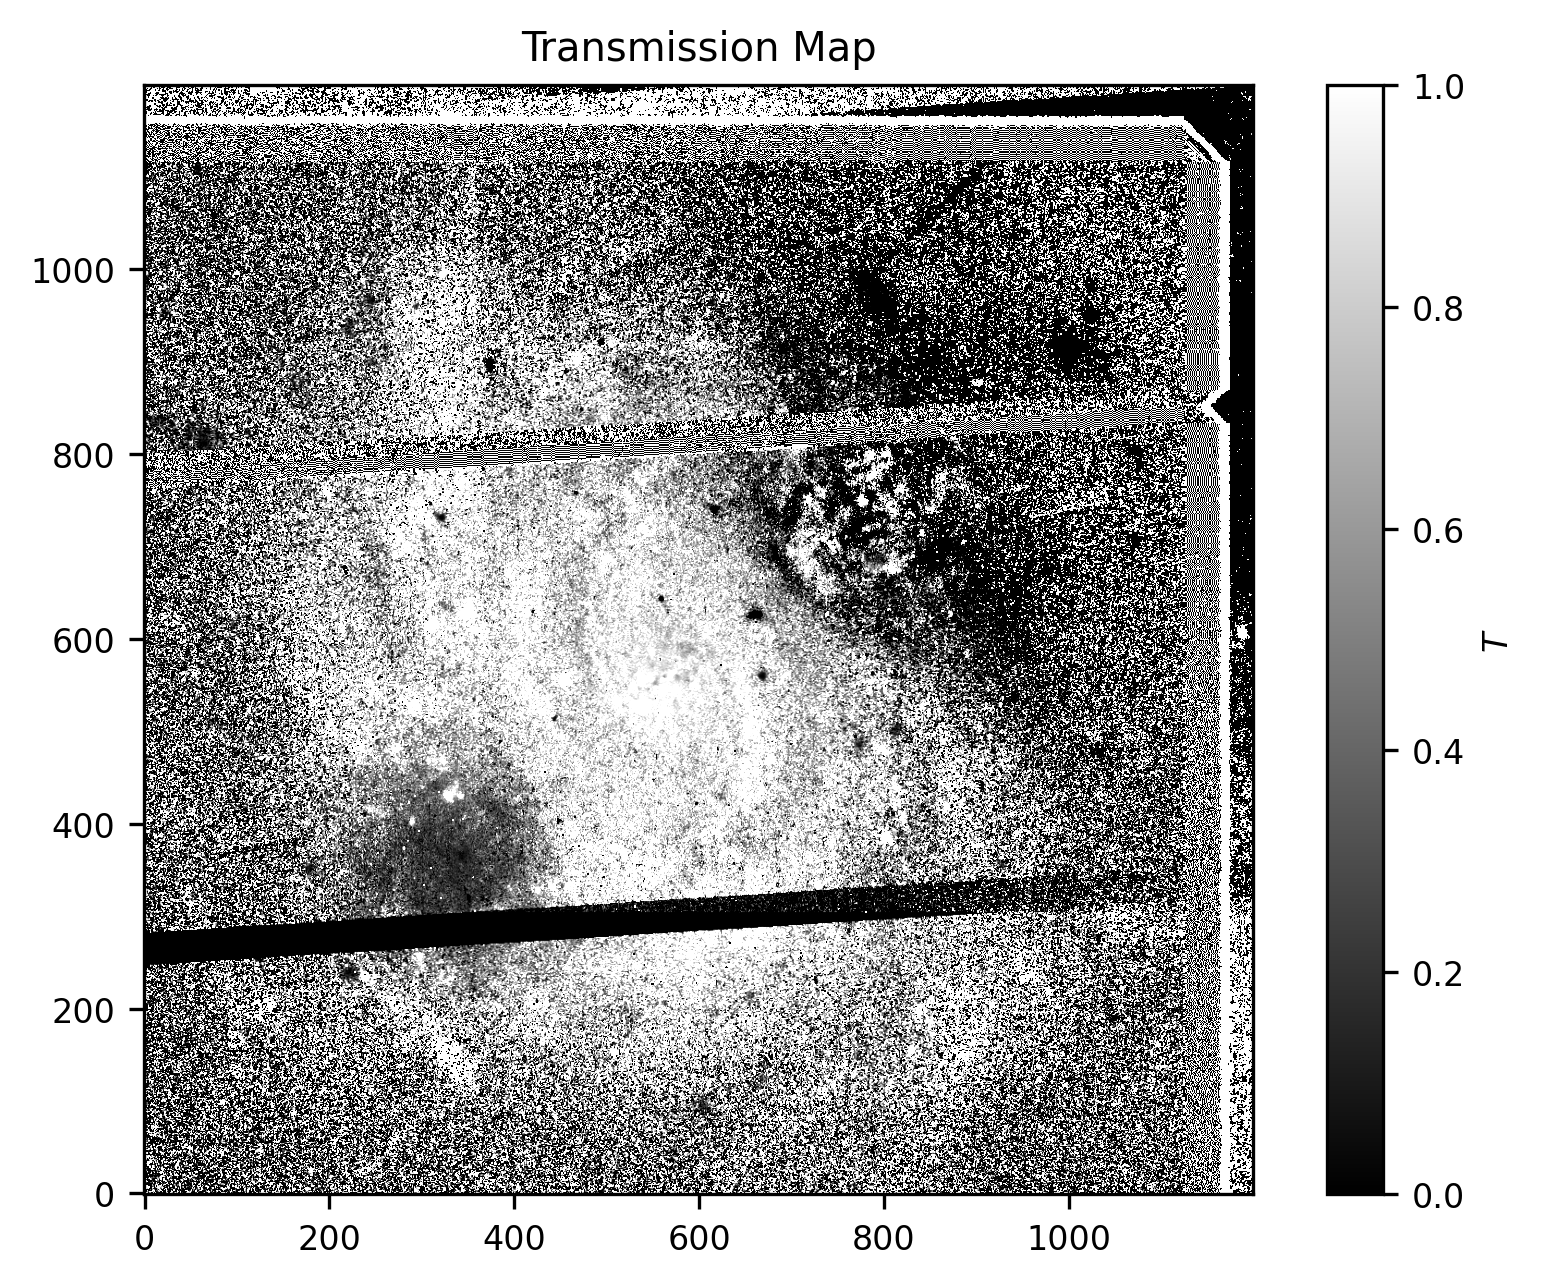

In [86]:
plt.figure(dpi=300)
plt.imshow(trans, origin='lower',vmin=0,vmax=1, cmap='gray')
plt.title('Transmission Map')
# plt.xlim(500,900)
# plt.ylim(500,900)
plt.colorbar(label='$T$')
plt.savefig(file+'_transmission_single.png')